In [211]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from preprocessing_layer import DataPreprocessing
from sklearn.preprocessing import StandardScaler
from scipy.special import expit
from sklearn.cluster import KMeans

In [2]:
filenames = glob.glob('Datathon*.csv')

In [3]:
pre_dat = pd.DataFrame({})
for ind, filename in enumerate(filenames):
    print(ind)
    tmp_dat = pd.read_csv(filename)
    pre_dat = pre_dat.append(tmp_dat)    
pre_dat.columns = ['BET_ID', 'BET_TRANS_ID', 'MATCH_BET_ID', 'ACCOUNT_ID',
       'COUNTRY_OF_RESIDENCE_NAME', 'PARENT_EVENT_ID', 'EVENT_ID', 'MATCH',
       'EVENT_NAME', 'EVENT_DT', 'OFF_DT', 'BID_TYP', 'STATUS_ID',
       'PLACED_DATE', 'TAKEN_DATE', 'SETTLED_DATE', 'CANCELLED_DATE',
       'SELECTION_NAME', 'PERSISTENCE_TYPE', 'BET_PRICE', 'PRICE_TAKEN',
       'INPLAY_BET', 'BET_SIZE', 'PROFIT_LOSS']
peek_dat = pd.read_csv('DSMDatathon_samplefile.txt', sep='\t')
pre_dat = peek_dat.append(pre_dat)

0
1

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)



2
3
4


In [4]:
pre_dat.loc[:, 'BID_TYP'] = pre_dat.loc[:, 'BID_TYP'].str.strip(' ')
pre_dat.loc[:, 'STATUS_ID'] = pre_dat.loc[:, 'STATUS_ID'].str.strip(' ')

In [5]:
pre_dat = pre_dat.loc[(pre_dat.STATUS_ID == 'S').values]

In [6]:
# correct the profit loss
c1 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS > 0))
c2 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS < 0))
c3 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS > 0))
c4 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS < 0))
pre_dat.loc[c1.values, 'correct_profit_loss'] = pre_dat.loc[c1.values, 'BET_SIZE'] * (pre_dat.loc[c1.values, 'PRICE_TAKEN'] -1)
pre_dat.loc[c2.values, 'correct_profit_loss'] = - pre_dat.loc[c2.values, 'BET_SIZE']
pre_dat.loc[c3.values, 'correct_profit_loss'] = pre_dat.loc[c3.values, 'BET_SIZE']
pre_dat.loc[c4.values, 'correct_profit_loss'] = - pre_dat.loc[c4.values, 'BET_SIZE'] * (pre_dat.loc[c4.values, 'PRICE_TAKEN'] -1)

In [186]:
semi_final = pd.read_csv('semi_and_final_features.csv')
semi_final.columns = ['Account_ID', 'EVENT_ID', 'TRANSACTION_COUNT', 'STATUS_ID',
       'INPLAY_BET', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE',
       'STDEV_BET_SIZE']

In [187]:
semi_final = semi_final.loc[(semi_final.STATUS_ID == 'S').values, :]

In [188]:
# map eventid to match
semi_final_map = {101187238: 'South Africa v New Zealand',
                  101187943: 'Australia v India',
                  101191295: 'New Zealand v Australia'}
semi_final.loc[:, 'MATCH'] = semi_final.loc[:, 'EVENT_ID'].map(semi_final_map)

In [10]:
submit = pd.read_csv('sample_submission_bet_size.csv')
submit.columns = ['Account_ID', 'Prediction']

In [11]:
pre_dat = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(submit.Account_ID), :]

In [13]:
pre_dat_by_account = pre_dat.groupby('ACCOUNT_ID')
pre_dat_by_account_event = pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])

In [94]:
def get_average_price(df):
    backs = df.BID_TYP == 'B'
    lays = df.BID_TYP == 'L'
    total_back_size = df.loc[backs.values, 'BET_SIZE'].sum() + 0.001
    total_lay_size = df.loc[lays.values, 'BET_SIZE'].sum() + 0.001
    avg_back_price = (df.loc[backs.values, 'BET_SIZE'] * df.loc[backs.values, 'PRICE_TAKEN']).sum() / total_back_size
    avg_lay_price = (df.loc[lays.values, 'BET_SIZE'] * df.loc[lays.values, 'PRICE_TAKEN']).sum() / total_lay_size
    back_share = df.loc[backs.values, 'BET_SIZE'].sum() / (total_back_size + total_lay_size)
    back_std = df.loc[backs.values, 'PRICE_TAKEN'].std()
    lay_std = df.loc[lays.values, 'PRICE_TAKEN'].std()
    return pd.Series({'avg_back_price': avg_back_price,
                      'avg_lay_price': avg_lay_price,
                      'back_share': back_share,
                      'back_std': back_std,
                      'lay_std': lay_std})

In [95]:
avg_price = pre_dat_by_account.apply(get_average_price)

In [96]:
avg_price.head(10)

,avg_back_price,avg_lay_price,back_share,back_std,lay_std
ACCOUNT_ID,,,,,
1000002,2.131243,0.000000,1.000000,10.273789,NaN
1000004,2.009621,1.226126,0.529321,9.114344,0.183689
1000005,1.164510,1.081237,0.459241,0.533567,0.223361
1000010,4.900702,1.240785,0.434367,58.987752,0.264042
1000014,1.499985,0.000000,0.999980,0.000000,NaN
1000017,1.558828,0.000000,1.000000,1.963770,NaN
1000019,3.978041,2.244549,0.513622,13.841371,0.305090
1000022,5.573535,2.129193,0.044491,4.889441,6.999629
1000023,1.351965,1.416883,0.579651,0.292586,0.215886


In [97]:
avg_bet_size = pre_dat_by_account_event['BET_SIZE'].sum()

In [98]:
avg_bet_size = avg_bet_size.groupby(level=0).mean()

In [99]:
avg_bet_size.head()

ACCOUNT_ID
1000002    2091.105015
1000004     259.069892
1000005    5599.937000
1000010     932.061019
1000014     100.000000
Name: BET_SIZE, dtype: float64

In [100]:
avg = pd.concat([avg_bet_size, avg_price], axis=1)

In [222]:
avg.head()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std,correct_profit_loss,segment
ACCOUNT_ID,,,,,,,,
1000002,2091.105015,2.131243,0.000000,1.000000,10.273789,0.000000,False,0
1000004,259.069892,2.009621,1.226126,0.529321,9.114344,0.183689,False,2
1000005,5599.937000,1.164510,1.081237,0.459241,0.533567,0.223361,False,2
1000010,932.061019,4.900702,1.240785,0.434367,58.987752,0.264042,False,1
1000014,100.000000,1.499985,0.000000,0.999980,0.000000,0.000000,True,0


In [151]:
quarter = pre_dat.loc[pre_dat.EVENT_ID.isin([101183237, 101183757, 101183885, 101184013])]

In [152]:
quarter.ACCOUNT_ID.nunique()

4925

In [153]:
quarter_by_account = quarter.groupby('ACCOUNT_ID')

In [154]:
quarter_profit = quarter_by_account['correct_profit_loss'].sum()

In [155]:
quarter_profit.head()

ACCOUNT_ID
1000002   -216.925587
1000004   -262.443860
1000005    -16.951520
1000010   -288.905712
1000014     50.000000
Name: correct_profit_loss, dtype: float64

In [156]:
is_quarter_profit = quarter_profit > 0

In [164]:
is_quarter_profit.value_counts()

False    2780
True     2145
dtype: int64

In [157]:
is_quarter_profit.head()

ACCOUNT_ID
1000002    False
1000004    False
1000005    False
1000010    False
1000014     True
Name: correct_profit_loss, dtype: bool

In [109]:
avg = pd.concat([avg, is_quarter_profit], axis=1)

In [119]:
avg.loc[:, ['back_std', 'lay_std']] = avg.loc[:, ['back_std', 'lay_std']].fillna(0)

In [160]:
avg1 = avg.dropna()

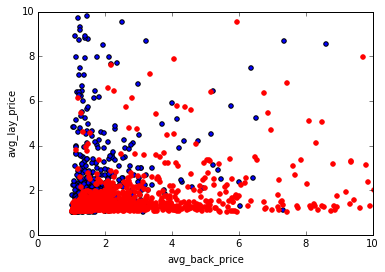

In [112]:
ax = avg1.loc[(avg1.correct_profit_loss == True).values].plot(kind='scatter', x='avg_back_price', y='avg_lay_price', xlim=(0, 10), ylim=(0, 10))
avg1.loc[(avg1.correct_profit_loss == False).values].plot(kind='scatter', x='avg_back_price', y='avg_lay_price', ax=ax, color='r', xlim=(0, 10), ylim=(0, 10))

In [236]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(avg1[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']], avg1['correct_profit_loss'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [237]:
pd.Series(rf.predict(avg1[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])).value_counts()

False    2781
True     2144
dtype: int64

In [238]:
to_submit = pd.DataFrame({
    'Account_ID': avg.index,
    'Prediction': rf.predict_proba(avg[['BET_SIZE', 'avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])[:, 1]})

In [167]:
to_submit = to_submit.set_index('Account_ID')

In [168]:
to_submit = to_submit.loc[submit.Account_ID.tolist()]

In [239]:
to_submit.head()

,Account_ID,Prediction
0,1000002,0.283881
1,1000004,0.040000
2,1000005,0.100000
3,1000010,0.020000
4,1000014,1.000000


In [170]:
to_submit = to_submit.fillna(0.2).reset_index()

In [171]:
to_submit.describe()

,Account_ID,Prediction
count,7374.000000,7374.000000
mean,1011060.910768,0.395981
std,6613.263866,0.380509
min,1000002.000000,0.000000
25%,1005685.750000,0.100000
50%,1010105.000000,0.200000
75%,1016848.750000,0.800000
max,1024189.000000,1.000000


In [240]:
to_submit.to_csv('prob_from_lay_back_with_makeup_data_more_estimators.csv', index=False)

In [173]:
# look at the new ones
pre_dat.ACCOUNT_ID.nunique()

6373

In [175]:
submit.Account_ID.nunique()

7374

In [179]:
newbies = submit.loc[~submit.Account_ID.isin(pre_dat.ACCOUNT_ID), 'Account_ID'].tolist()

In [189]:
newbie_dat = semi_final.loc[semi_final.Account_ID.isin(newbies), :]

In [191]:
newbie_dat.head()

,Account_ID,EVENT_ID,TRANSACTION_COUNT,STATUS_ID,INPLAY_BET,AVG_BET_SIZE,MAX_BET_SIZE,MIN_BET_SIZE,STDEV_BET_SIZE,MATCH,total
246,1000168,101187238,1,S,N,1261.438500,1261.43850,1261.438500,0.000000,South Africa v New Zealand,1261.43850
247,1000168,101187238,3,S,N,870.866790,1263.33540,85.929570,679.775573,South Africa v New Zealand,2612.60037
249,1000168,101187943,1,S,N,858.221000,858.22100,858.221000,0.000000,Australia v India,858.22100
250,1000168,101187943,7,S,Y,622.984914,1467.46360,12.241438,548.878251,Australia v India,4360.89440
251,1000168,101187943,15,S,Y,187.865520,585.94803,19.880548,187.252063,Australia v India,2817.98280


In [215]:
# get the average bet
newbie_dat.loc[:, 'total'] = newbie_dat.loc[:, 'TRANSACTION_COUNT'] * newbie_dat.loc[:, 'AVG_BET_SIZE']

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [192]:
newbie_dat_by_account_event = newbie_dat.groupby(['Account_ID', 'EVENT_ID'])

In [193]:
new_game_total = newbie_dat_by_account_event['total'].sum()

In [195]:
new_game_avg = new_game_total.groupby(level=0).mean()

In [212]:
rfg = RandomForestRegressor(n_estimators=20)

In [216]:
rfg.fit(avg.loc[:, ['BET_SIZE']], avg.loc[:, ['avg_back_price', 'avg_lay_price', 'back_share', 'back_std', 'lay_std']])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [219]:
new_game_avg = pd.DataFrame(new_game_avg)

In [224]:
new_game_avg.head()

,total
Account_ID,
1000168,5955.568535
1000207,2000.000000
1000249,901.360094
1000274,228.645164
1000304,523.654400


In [223]:
make_up_data_np = rfg.predict(new_game_avg.iloc[:, [0]])

In [225]:
make_up_data = pd.DataFrame(
    {'BET_SIZE': new_game_avg.total,
     'avg_back_price': make_up_data_np[:, 0],
     'avg_lay_price': make_up_data_np[:, 1],
     'back_share': make_up_data_np[:, 2],
     'back_std': make_up_data_np[:, 3],
     'lay_std': make_up_data_np[:, 4]},
    index=newbies)

In [226]:
make_up_data.head()

,BET_SIZE,avg_back_price,avg_lay_price,back_share,back_std,lay_std
1013818,208.65900,1.855905,2.299692,0.533008,2.500325,3.091612
1014436,2000.00000,1.420799,0.000000,0.999999,0.000000,0.000000
1017244,233.04546,1.606203,0.987962,0.688629,30.426378,5.325808
1014050,315.24000,2.078421,1.687355,0.473537,1.275486,0.991969
1001853,300.00000,3.494748,1.214900,0.317269,25.170578,0.216548


In [228]:
avg = pd.concat([avg, make_up_data])

In [230]:
avg.shape

(7374, 8)